In [3]:
#package
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

import spacy
import string
from nltk.corpus import stopwords
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Load data
path = 'D:/USA 2021 Spring/Shopee Code League/Data_science/Product_review/train.csv'
traindf = pd.read_csv(path)

In [6]:
path = 'D:/USA 2021 Spring/Shopee Code League/Data_science/Product_review/test.csv'
testdf = pd.read_csv(path)

In [7]:
display(traindf.head(), testdf.head())

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


# Step 1 Exploration and Data Clean

## Data information

In [8]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146811 entries, 0 to 146810
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  146811 non-null  int64 
 1   review     146811 non-null  object
 2   rating     146811 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [9]:
traindf["rating"].value_counts()

4    41865
5    41515
3    35941
1    14785
2    12705
Name: rating, dtype: int64

## Text Pre-processing

In [10]:
from sklearn.model_selection import train_test_split

msg_train,msg_valid,rating_train,rating_valid = train_test_split(traindf['review'],traindf['rating'])

print(len(msg_train), len(rating_train), len(msg_valid),len(rating_valid))

110108 110108 36703 36703


In [11]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_train = le.fit_transform(rating_train)
train_Y = np_utils.to_categorical(le_train)

le_valid = le.fit_transform(rating_valid)
valid_Y =np_utils.to_categorical(le_valid)

Using TensorFlow backend.


In [12]:
train_Y

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [13]:
# normalize
## remove negation words from stopword_list
nlp = spacy.load('en_core_web_lg')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [14]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [15]:
norm_train_msg = normalize_corpus(msg_train, html_stripping=False)
norm_valid_msg = normalize_corpus(msg_valid, html_stripping=False)

In [16]:
norm_train_msg[0]

'valvular tz'

In [17]:
# encode: word to index
##Tokenize
tokenized_train = [tokenizer.tokenize(text) for text in norm_train_msg]
tokenized_valid = [tokenizer.tokenize(text) for text in norm_valid_msg]

In [18]:
tokenized_train[0]

['valvular', 'tz']

In [19]:
## build encode list
from collections import Counter
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)

print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 47694
Sample slice of vocabulary map: {'fast': 11, 'shipping': 12, 'securely': 13, 'item': 14, 'thank': 15, 'good': 16, 'job': 17, 'quality': 18, 'accommodate': 19, 'product': 20}


In [20]:
## Convert tokenized text reviews to numeric vectors
from keras.preprocessing import sequence
max_len = np.max([len(review) for review in tokenized_train])
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len)

valid_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_valid]
valid_X = sequence.pad_sequences(valid_X, maxlen=max_len)

In [21]:
train_X[3000]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  20,  18,
         8,  20, 114,  16,  42, 129,  16])

In [22]:
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape,'Valid review vectors shape:', valid_X.shape)

Max length of train review vectors: 176
Train review vectors shape: (110108, 176) Valid review vectors shape: (36703, 176)


In [38]:
train_X.shape[1]

176

# Step2 Modeling

In [24]:
from sklearn import metrics
def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions 

In [25]:
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

In [26]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

In [27]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    #level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_frame = pd.DataFrame(data=cm, 
                            index = [['Actual']*total_classes,classes],
                            columns = [['Predicted']*total_classes,classes]) 
    print (cm_frame)

In [28]:
def display_model_performance_metrics(true_labels, predicted_labels, classes):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

## logistic regression

In [32]:
def standard_scaler(X):
    mean = X.mean(0)
    sd = X.std(0)
    return (X - mean)/sd 
def softmax(z):
    return np.exp(z)/(np.exp(z).sum())

def softmax_byrow(Z):
    return (np.exp(Z)/(np.exp(Z).sum(1)[:,None]))

def make_I_matrix(y):
    I = np.zeros(shape = (len(y), len(np.unique(y))), dtype = int)
    for j, target in enumerate(np.unique(y)):
        I[:,j] = (y == target)
    return I

In [33]:
class MulticlassLogisticRegression:
    
    def fit(self, X, y, n_iter, lr, standardize = True, has_intercept = False):
        
        ### Record Info ###
        if standardize:
            X = standard_scaler(X) 
        if not has_intercept:
            ones = np.ones(X.shape[0]).reshape(-1, 1)
            X = np.concatenate((ones, X), axis = 1)
        self.X = X
        self.N, self.D = X.shape
        self.y = y
        self.K = len(np.unique(y))
        self.n_iter = n_iter
        self.lr = lr
        
        ### Fit B ###
        B = np.random.randn(self.D*self.K).reshape((self.D, self.K))
        self.I = make_I_matrix(self.y)
        for i in range(n_iter):
            Z = np.dot(self.X, B)
            P = softmax_byrow(Z)
            gradient = -np.dot(self.X.T, self.I - P)
            B -= lr*gradient
        
        ### Return Values ###
        self.B = B
        self.Z = np.dot(self.X, B)
        self.P = softmax_byrow(self.Z)
        self.yhat = self.P.argmax(1)

In [85]:
multiclass_model = MulticlassLogisticRegression()
multiclass_model.fit(train_X, rating_train, 100, 0.1)
print('In-sample accuracy: '  + str(np.mean(multiclass_model.yhat == rating_train)))

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In-sample accuracy: 0.0


In [39]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
lr = LogisticRegression(penalty='l2', max_iter=100, C=1)

In [40]:
print(len(train_X), len(rating_train), len(valid_X),len(rating_valid))

110108 110108 36703 36703


In [41]:
lr_predictions = train_predict_model(classifier=lr, 
                                         train_features=train_X, train_labels=rating_train,
                                         test_features=valid_X, test_labels=rating_valid)


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=lr_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.2777
Precision: 0.2489
Recall: 0.2777
F1 Score: 0.1904

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.20      0.04      0.07      3634
           2       0.12      0.00      0.00      3215
           3       0.23      0.10      0.14      8945
           4       0.29      0.81      0.42     10436
           5       0.29      0.06      0.11     10473

    accuracy                           0.28     36703
   macro avg       0.22      0.20      0.15     36703
weighted avg       0.25      0.28      0.19     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                    
                 1  2     3     4    5
Actual 1       146  3   533  2672  280
       2        73  2   340  2586  214
       3       180  2   877  7404  482
       4       169  6  1076  8491  694
       5       155  4  1052  8

## SVM

In [31]:
svm = SGDClassifier(loss='hinge', max_iter=100)

In [32]:
svm_predictions = train_predict_model(classifier=svm, 
                                             train_features=train_X, train_labels=rating_train,
                                             test_features=valid_X, test_labels=rating_valid)
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=svm_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.2222
Precision: 0.2382
Recall: 0.2222
F1 Score: 0.2066

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.12      0.13      0.12      3645
           2       0.11      0.14      0.13      3173
           3       0.24      0.48      0.32      8982
           4       0.29      0.15      0.20     10495
           5       0.26      0.13      0.17     10408

    accuracy                           0.22     36703
   macro avg       0.20      0.21      0.19     36703
weighted avg       0.24      0.22      0.21     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                        
                 1     2     3     4     5
Actual 1       465   494  1668   514   504
       2       409   458  1589   337   380
       3       922   937  4317  1397  1409
       4      1063  1156  5276  1585  1415
      

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


## DNN

In [98]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization

In [107]:
def construct_deepnn_architecture(vocab_size,input_length):
    dnn_model = Sequential()
    dnn_model.add(Embedding(vocab_size,128, input_length = input_length, name="input_with_embedding"))
    dnn_model.add(GlobalAveragePooling1D( name="Global_Average_Pooling"))
    dnn_model.add(Dense(64, activation="relu", name="layer_1"))
    dnn_model.add(Dense(32, activation="relu", name="layer_2"))
    dnn_model.add(Dense(5, activation="softmax", name="softmax_output"))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [108]:
dnn_embedding = construct_deepnn_architecture(vocab_size,train_X.shape[1])

In [109]:
print(dnn_embedding.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_with_embedding (Embedd (None, 176, 128)          6104832   
_________________________________________________________________
Global_Average_Pooling (Glob (None, 128)               0         
_________________________________________________________________
layer_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
layer_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
softmax_output (Dense)       (None, 5)                 165       
Total params: 6,115,333
Trainable params: 6,115,333
Non-trainable params: 0
_________________________________________________________________
None


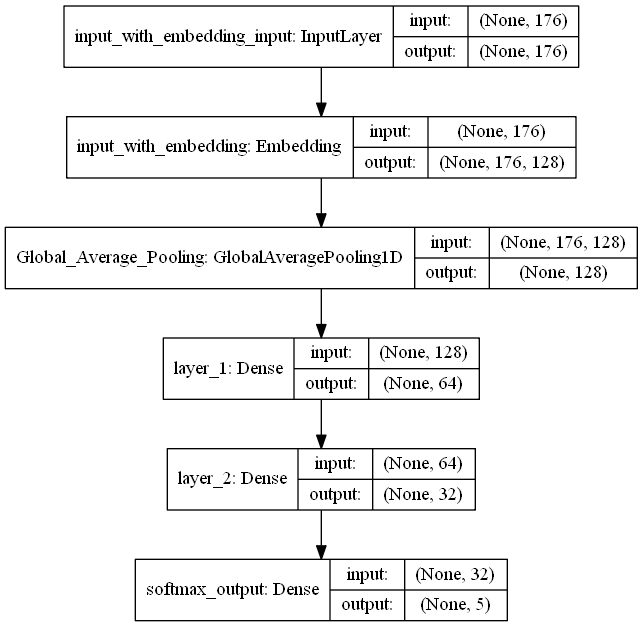

In [110]:
from keras.utils.vis_utils import plot_model
plot_model(dnn_embedding, to_file='dmm_model.png', show_shapes=True, show_layer_names=True)

In [111]:
batch_size = 100
dnn_embedding.fit(train_X, train_Y, epochs=5, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
dnn_embedding

Train on 99097 samples, validate on 11011 samples
Epoch 1/5
99097/99097 [==============================] - 76s 772us/step - loss: 1.3235 - accuracy: 0.3600 - val_loss: 1.1792 - val_accuracy: 0.4256
Epoch 2/5
99097/99097 [==============================] - 80s 803us/step - loss: 1.1438 - accuracy: 0.4463 - val_loss: 1.1323 - val_accuracy: 0.4488
Epoch 3/5
99097/99097 [==============================] - 78s 788us/step - loss: 1.0833 - accuracy: 0.4752 - val_loss: 1.1239 - val_accuracy: 0.4651
Epoch 4/5
99097/99097 [==============================] - 78s 790us/step - loss: 1.0407 - accuracy: 0.4968 - val_loss: 1.1253 - val_accuracy: 0.4645
Epoch 5/5
99097/99097 [==============================] - 77s 781us/step - loss: 1.0001 - accuracy: 0.5146 - val_loss: 1.1272 - val_accuracy: 0.4641


In [112]:
y_pred = dnn_embedding.predict_classes(valid_X)
dnn_predictions = le.inverse_transform(y_pred)

In [113]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=dnn_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.4658
Precision: 0.4648
Recall: 0.4658
F1 Score: 0.3892

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.53      0.76      0.62      3634
           2       0.49      0.23      0.31      3215
           3       0.49      0.63      0.55      8945
           4       0.43      0.74      0.54     10436
           5       0.45      0.02      0.04     10473

    accuracy                           0.47     36703
   macro avg       0.48      0.48      0.41     36703
weighted avg       0.46      0.47      0.39     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                      
                 1    2     3     4    5
Actual 1      2747  233   506   136   12
       2       965  737  1193   310   10
       3       808  424  5640  2052   21
       4       325   67  2066  7769  209
       5       342

## LSTM

In [114]:
def construct_lstm_architecture(num_input_features):
    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=num_input_features, output_dim=128,input_length=max_len, name="input_with_embedding"))
    lstm_model.add(SpatialDropout1D(0.2))
    lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, name="LSTM_layer"))
    lstm_model.add(Dense(32, activation="relu", name="relu_layer"))
    lstm_model.add(Dense(5, activation="softmax",name="softmax_layer"))

    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return lstm_model

In [115]:
lstm_embedding = construct_lstm_architecture(num_input_features=vocab_size)

In [116]:
print(lstm_embedding.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_with_embedding (Embedd (None, 176, 128)          6104832   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 176, 128)          0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 64)                49408     
_________________________________________________________________
relu_layer (Dense)           (None, 32)                2080      
_________________________________________________________________
softmax_layer (Dense)        (None, 5)                 165       
Total params: 6,156,485
Trainable params: 6,156,485
Non-trainable params: 0
_________________________________________________________________
None


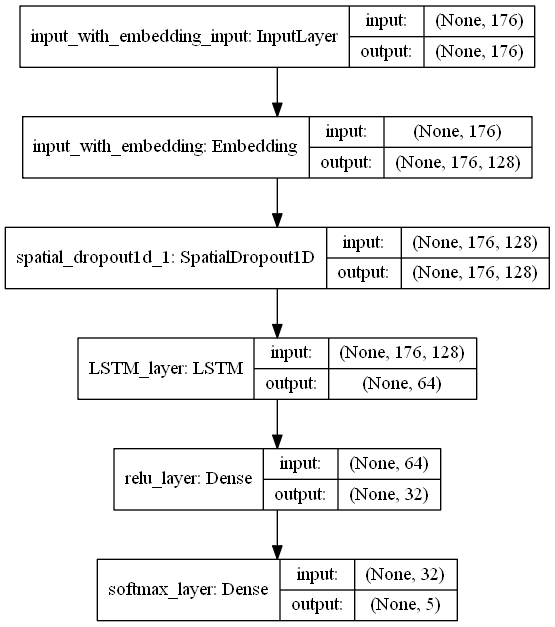

In [117]:
plot_model(lstm_embedding, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [118]:
batch_size = 100
lstm_embedding.fit(train_X, train_Y, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
lstm_embedding

Train on 99097 samples, validate on 11011 samples
Epoch 1/10
99097/99097 [==============================] - 295s 3ms/step - loss: 1.1728 - accuracy: 0.4383 - val_loss: 1.0846 - val_accuracy: 0.4713
Epoch 2/10
99097/99097 [==============================] - 285s 3ms/step - loss: 1.0359 - accuracy: 0.4966 - val_loss: 1.0942 - val_accuracy: 0.4732
Epoch 3/10
99097/99097 [==============================] - 284s 3ms/step - loss: 0.9609 - accuracy: 0.5333 - val_loss: 1.1193 - val_accuracy: 0.4724
Epoch 4/10
99097/99097 [==============================] - 288s 3ms/step - loss: 0.8977 - accuracy: 0.5691 - val_loss: 1.1512 - val_accuracy: 0.4604
Epoch 5/10
99097/99097 [==============================] - 290s 3ms/step - loss: 0.8356 - accuracy: 0.6037 - val_loss: 1.2062 - val_accuracy: 0.4592
Epoch 6/10
99097/99097 [==============================] - 287s 3ms/step - loss: 0.7747 - accuracy: 0.6367 - val_loss: 1.2847 - val_accuracy: 0.4624
Epoch 7/10
99097/99097 [==============================] - 287s

In [119]:
y_pred = lstm_embedding.predict_classes(valid_X)
lstm_predictions = le.inverse_transform(y_pred)

In [120]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=lstm_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.4591
Precision: 0.4542
Recall: 0.4591
F1 Score: 0.4532

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.60      0.61      0.61      3634
           2       0.38      0.35      0.37      3215
           3       0.52      0.55      0.53      8945
           4       0.43      0.52      0.47     10436
           5       0.39      0.29      0.34     10473

    accuracy                           0.46     36703
   macro avg       0.47      0.47      0.46     36703
weighted avg       0.45      0.46      0.45     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                        
                 1     2     3     4     5
Actual 1      2232   633   526   143   100
       2       604  1128   954   286   243
       3       513   739  4931  1342  1420
       4       184   222  1533  5476  3021
      

## LSTM + FastText

In [143]:
#https://github.com/emmanuellaanggi/disaster_tweet_sentiment/blob/master/(Medium)_Text_Classification_Disaster_Tweet_.ipynb
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [146]:
import codecs
from tqdm import tqdm

print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1927it [00:00, 9469.90it/s]

loading word embeddings...


1999996it [03:34, 9325.71it/s]

found 1999996 word vectors


In [148]:
MAX_NB_WORDS = 100000
embed_dim = 300 

In [149]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(vocab_map)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in vocab_map.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 27830


In [150]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['talag' 'dineli' 'topppppppppp' 'dehdehdeh' 'kasiiiiiih' 'anlakas'
 'racun2' 'bklo' 'denganproduk' 'diexpedisinyaaaaaa']


In [162]:
def construct_lstm_embedding_architecture(num_input_features):
    lstm_em_model = Sequential()
    lstm_em_model.add(Embedding(input_dim=num_input_features, output_dim=embed_dim,
                                input_length=max_len, weights=[embedding_matrix],trainable=False))
    lstm_em_model.add(SpatialDropout1D(0.2))
    lstm_em_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    lstm_em_model.add(Dense(32, activation="relu"))
    lstm_em_model.add(Dropout(0.4))
    lstm_em_model.add(Dense(5, activation="softmax"))

    lstm_em_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return lstm_em_model

In [163]:
lstm_embedding_fast = construct_lstm_embedding_architecture(num_input_features=vocab_size+1)

In [164]:
print(lstm_embedding_fast.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 176, 300)          14307300  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 176, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_69 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 165       
Total params: 14,402,985
Trainable params: 95,685
Non-trainable params: 14,307,300
____________________________________

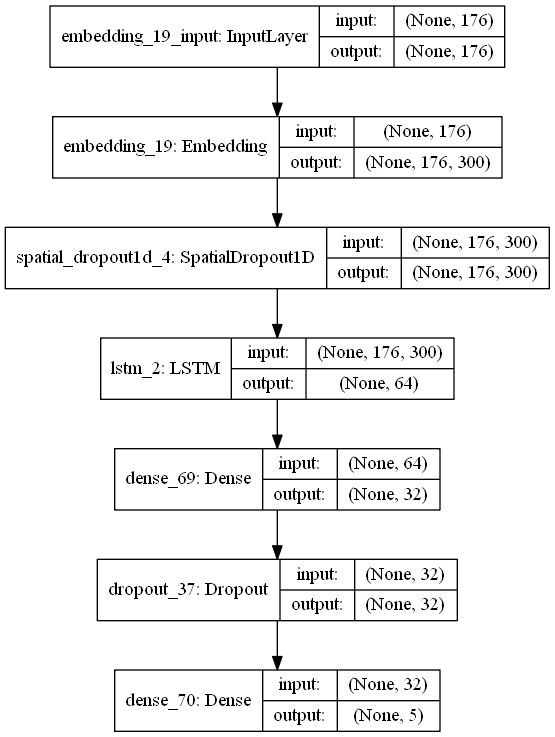

In [165]:
plot_model(lstm_embedding_fast, to_file='lstm_em_model.png', show_shapes=True, show_layer_names=True)

In [166]:
batch_size = 100
lstm_embedding_fast.fit(train_X, train_Y, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
lstm_embedding_fast

Train on 99097 samples, validate on 11011 samples
Epoch 1/10
99097/99097 [==============================] - 271s 3ms/step - loss: 1.2545 - accuracy: 0.4088 - val_loss: 1.1318 - val_accuracy: 0.4633
Epoch 2/10
99097/99097 [==============================] - 264s 3ms/step - loss: 1.1669 - accuracy: 0.4463 - val_loss: 1.1061 - val_accuracy: 0.4626
Epoch 3/10
99097/99097 [==============================] - 261s 3ms/step - loss: 1.1383 - accuracy: 0.4555 - val_loss: 1.0869 - val_accuracy: 0.4765
Epoch 4/10
99097/99097 [==============================] - 261s 3ms/step - loss: 1.1163 - accuracy: 0.4655 - val_loss: 1.0808 - val_accuracy: 0.4802
Epoch 5/10
99097/99097 [==============================] - 262s 3ms/step - loss: 1.1227 - accuracy: 0.4626 - val_loss: 1.0855 - val_accuracy: 0.4674
Epoch 6/10
99097/99097 [==============================] - 263s 3ms/step - loss: 1.1035 - accuracy: 0.4704 - val_loss: 1.0746 - val_accuracy: 0.4826
Epoch 7/10
99097/99097 [==============================] - 262s

In [167]:
y_pred = lstm_embedding_fast.predict_classes(valid_X)
lstm_em_predictions = le.inverse_transform(y_pred)

In [168]:
lstm_em_predictions

array([3, 4, 3, ..., 4, 4, 5], dtype=int64)

In [169]:
display_model_performance_metrics(true_labels=rating_valid, predicted_labels=lstm_em_predictions,
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.4807
Precision: 0.4998
Recall: 0.4807
F1 Score: 0.4267

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.55      0.78      0.64      3645
           2       0.69      0.21      0.32      3173
           3       0.52      0.63      0.57      8982
           4       0.43      0.72      0.53     10495
           5       0.48      0.09      0.15     10408

    accuracy                           0.48     36703
   macro avg       0.53      0.49      0.44     36703
weighted avg       0.50      0.48      0.43     36703


Prediction Confusion Matrix:
------------------------------
         Predicted                      
                 1    2     3     4    5
Actual 1      2841   85   574   142    3
       2      1022  664  1194   285    8
       3       798  174  5670  2271   69
       4       258   24  1762  7538  913
       5       264

In [ ]:
#https://www.analyticsvidhya.com/blog/2015/10/6-practices-enhance-performance-text-classification-model/